C:\Users\ander\AppData\Local\Temp\ipykernel_9832\3871191709.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_lag_{i}'] = df[col].shift(i)
C:\Users\ander\AppData\Local\Temp\ipykernel_9832\3871191709.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_lag_{i}'] = df[col].shift(i)
C:\Users\ander\AppData\Local\Temp\ipykernel_9832\3871191709.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joini

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

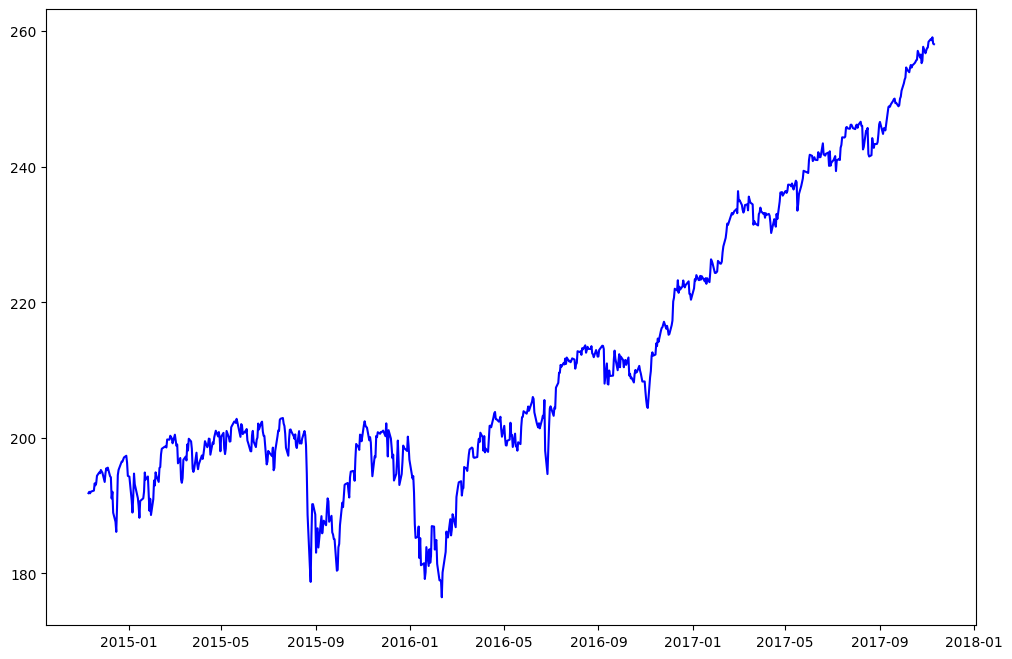

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pygam import LinearGAM, s
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.cross_decomposition import PLSRegression
from sklearn.feature_selection import RFE

def create_date_features(df):
    df['DayOfYear'] = df.index.dayofyear
    df['WeekOfYear'] = df.index.isocalendar().week
    df['Month'] = df.index.month
    df['Year'] = df.index.year

    # Sine-cosine encoding for cyclical features
    df['DayOfYear_sin'] = np.sin(2 * np.pi * df['DayOfYear'] / 365.25)
    df['DayOfYear_cos'] = np.cos(2 * np.pi * df['DayOfYear'] / 365.25)
    df['WeekOfYear_sin'] = np.sin(2 * np.pi * df['WeekOfYear'] / 52)
    df['WeekOfYear_cos'] = np.cos(2 * np.pi * df['WeekOfYear'] / 52)
    df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
    df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)

    return df

# Load the data
df = pd.read_csv('../../data/stock-market/ETFs/spy.us.txt')

# Convert Date column to datetime and set it as the index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Create lagged features
for i in range(12, 37):
    for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
        df[f'{col}_lag_{i}'] = df[col].shift(i)

# Drop rows with NaN values
df.dropna(inplace=True)

# Feature engineering: Extract date-related features and create sine-cosine embeddings
df = create_date_features(df)

# Define the target variable and features
y = df['Close']
features = [col for col in df.columns if col != 'Close']
X = df[features]

# Split the data into training, validation, and testing sets
end_date = df.index.max()
test_start_date = end_date - pd.DateOffset(years=1)
validation_start_date = test_start_date - pd.DateOffset(years=1)

train_X = X[X.index < validation_start_date]
train_y = y[y.index < validation_start_date]
validation_X = X[(X.index >= validation_start_date) & (X.index < test_start_date)]
validation_y = y[(y.index >= validation_start_date) & (y.index < test_start_date)]
test_X = X[X.index >= test_start_date]
test_y = y[y.index >= test_start_date]

# Normalize features
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)
train_X_normalized = X_normalized[X.index < validation_start_date]
validation_X_normalized = X_normalized[(X.index >= validation_start_date) & (X.index < test_start_date)]
test_X_normalized = X_normalized[X.index >= test_start_date]

# PLS dimensionality reduction
pls = PLSRegression(n_components=X.shape[1])  # Start with max components
pls.fit(train_X_normalized, train_y)
cumulative_variance = np.cumsum(np.sum(pls.x_scores_**2, axis=0) / np.sum(pls.x_scores_**2))
n_components = np.argmax(cumulative_variance >= 0.95) + 1  # Number of components for 95% variance

pls = PLSRegression(n_components=n_components)
X_pls = pls.fit_transform(X_normalized, y)[0]
train_X_pls = X_pls[:len(train_X)]
validation_X_pls = X_pls[len(train_X):len(train_X)+len(validation_X)]
test_X_pls = X_pls[len(train_X)+len(validation_X):]

# RFE feature selection
rfe = RFE(estimator=LinearRegression(), n_features_to_select=10)
X_rfe = rfe.fit_transform(X_pls, y)
train_X_rfe = X_rfe[:len(train_X)]
validation_X_rfe = X_rfe[len(train_X):len(train_X)+len(validation_X)]
test_X_rfe = X_rfe[len(train_X)+len(validation_X):]

# Save train, validation, and test sets after PLS and RFE transformations
pd.DataFrame(train_X_rfe).to_csv('train_X_pls_rfe.csv', index=False)
pd.DataFrame(validation_X_rfe).to_csv('validation_X_pls_rfe.csv', index=False)
pd.DataFrame(test_X_rfe).to_csv('test_X_pls_rfe.csv', index=False)
train_y.to_csv('train_y_pls_rfe.csv', index=False)
validation_y.to_csv('validation_y_pls_rfe.csv', index=False)
test_y.to_csv('test_y_pls_rfe.csv', index=False)

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Additive Model': LinearGAM(s(0, n_splines=20, lam=0.1) + 
                s(1, n_splines=20, lam=0.1) + 
                s(2, n_splines=20, lam=0.1) + 
                s(3, n_splines=20, lam=0.1) + 
                s(4, n_splines=20, lam=0.1)),
    'SVR': SVR(kernel='linear', C=1, epsilon=0.1),
    'Random Forest': RandomForestRegressor(
        n_estimators=200,
        max_depth=10,
        max_features='sqrt',
        random_state=42
    ),
    'Neural Network': MLPRegressor(hidden_layer_sizes=(50, 50), max_iter=2000, learning_rate_init=0.001, alpha=0.01),
}

# Decomposition (Additive Model)
decomposition = seasonal_decompose(train_y, model='additive', period=365)
train_y_detrended = train_y - decomposition.trend.dropna()

# Train models and generate predictions using both training and validation data where applicable.
predictions = {}
for name, model in models.items():
    if name == 'Linear Regression':
        model.fit(train_X_rfe, train_y)
        full_pred = model.predict(X_rfe)
        pred = full_pred[len(train_X):]
    else:
        model.fit(train_X_rfe, train_y if name == 'Additive Model' else train_y)
        pred = model.predict(test_X_rfe)
        if name == 'Additive Model':
          model.fit(train_X_rfe, train_y)
    predictions[name] = pred

# Add actual values for comparison in predictions dictionary.
for name in predictions.keys():
    predictions[name]['Actual_Test'] = test_y.values

# Calculate and display RMSE for each model on the test set.
for name in predictions.keys():
    rmse_test = np.sqrt(mean_squared_error(predictions[name]['Actual_Test'], predictions[name]['Test']))
    print(f"{name} Test RMSE: {rmse_test:.2f}")

# Plot actual vs. predicted prices for the last year.
plt.figure(figsize=(12, 8))
last_3_years = df.index[-1] - pd.DateOffset(years=3)
df_last_3_years = df[df.index >= last_3_years]
plt.plot(df_last_3_years.index, df_last_3_years['Close'], label='Close Price', color='blue')

# Plot each model's predictions on the test set.
for name in predictions.keys():
    plt.plot(test_y.index, predictions[name]['Test'], label=f"{name} Predictions")

plt.title("Actual vs Predicted Close Prices (Last Year with PLS and RFE)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

C:\Users\ander\AppData\Local\Temp\ipykernel_9832\3974195436.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_lag_{i}'] = df[col].shift(i)
C:\Users\ander\AppData\Local\Temp\ipykernel_9832\3974195436.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_lag_{i}'] = df[col].shift(i)
C:\Users\ander\AppData\Local\Temp\ipykernel_9832\3974195436.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joini

Linear Regression Validation RMSE: 4.00
Linear Regression Test RMSE: 3.88
Additive Model Validation RMSE: 4.40
Additive Model Test RMSE: 4.23
SVR Validation RMSE: 4.12
SVR Test RMSE: 3.93
Random Forest Validation RMSE: 13.50
Random Forest Test RMSE: 42.35
Neural Network Validation RMSE: 5.93
Neural Network Test RMSE: 11.09


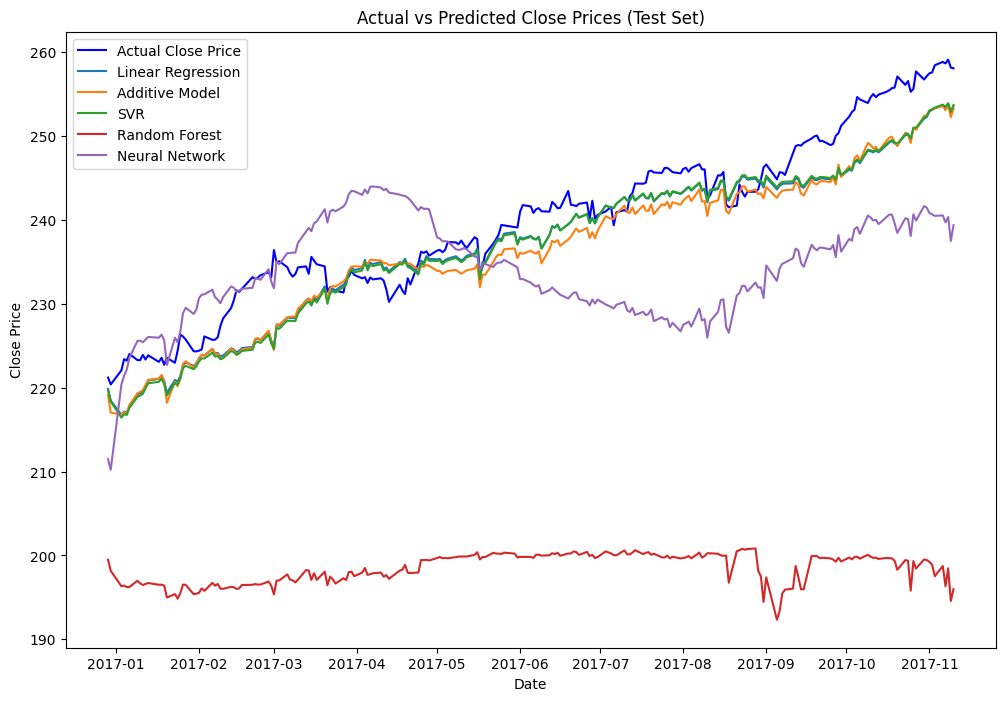

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pygam import LinearGAM, s
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.cross_decomposition import PLSRegression
from sklearn.feature_selection import RFE

def create_date_features(df):
    df['DayOfYear'] = df.index.dayofyear
    df['WeekOfYear'] = df.index.isocalendar().week
    df['Month'] = df.index.month
    df['Year'] = df.index.year

    # Sine-cosine encoding for cyclical features
    df['DayOfYear_sin'] = np.sin(2 * np.pi * df['DayOfYear'] / 365.25)
    df['DayOfYear_cos'] = np.cos(2 * np.pi * df['DayOfYear'] / 365.25)
    df['WeekOfYear_sin'] = np.sin(2 * np.pi * df['WeekOfYear'] / 52)
    df['WeekOfYear_cos'] = np.cos(2 * np.pi * df['WeekOfYear'] / 52)
    df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
    df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)

    return df

# Load the data
df = pd.read_csv('../../data/stock-market/ETFs/spy.us.txt')

# Convert Date column to datetime and set it as the index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Create lagged features
for i in range(12, 37):
    for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
        df[f'{col}_lag_{i}'] = df[col].shift(i)

# Drop rows with NaN values
df.dropna(inplace=True)

# Feature engineering: Extract date-related features and create sine-cosine embeddings
df = create_date_features(df)

# Define the target variable and features
y = df['Close']
features = [col for col in df.columns if col != 'Close']
X = df[features]

# Split the data into training, validation, and testing sets (60% train, 20% validation, 20% test)
train_end_date = df.index.max() - pd.DateOffset(days=int(len(df) * 0.2))
validation_end_date = df.index.max() - pd.DateOffset(days=int(len(df) * 0.1))

train_X = X[X.index < train_end_date]
train_y = y[X.index < train_end_date]
validation_X = X[(X.index >= train_end_date) & (X.index < validation_end_date)]
validation_y = y[(y.index >= train_end_date) & (y.index < validation_end_date)]
test_X = X[X.index >= validation_end_date]
test_y = y[X.index >= validation_end_date]

# Normalize features using MinMaxScaler
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)
train_X_normalized = X_normalized[X.index < train_end_date]
validation_X_normalized = X_normalized[(X.index >= train_end_date) & (X.index < validation_end_date)]
test_X_normalized = X_normalized[X.index >= validation_end_date]

# PLS dimensionality reduction
pls = PLSRegression(n_components=X.shape[1])  # Start with max components
pls.fit(train_X_normalized, train_y)
cumulative_variance = np.cumsum(np.sum(pls.x_scores_**2, axis=0) / np.sum(pls.x_scores_**2))
n_components = np.argmax(cumulative_variance >= 0.95) + 1  # Number of components for 95% variance

pls = PLSRegression(n_components=n_components)
X_pls = pls.fit_transform(X_normalized, y)[0]
train_X_pls = X_pls[:len(train_X)]
validation_X_pls = X_pls[len(train_X):len(train_X) + len(validation_X)]
test_X_pls = X_pls[len(train_X) + len(validation_X):]

# RFE feature selection
rfe = RFE(estimator=LinearRegression(), n_features_to_select=10)
X_rfe = rfe.fit_transform(X_pls, y)
train_X_rfe = X_rfe[:len(train_X)]
validation_X_rfe = X_rfe[len(train_X):len(train_X) + len(validation_X)]
test_X_rfe = X_rfe[len(train_X) + len(validation_X):]

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Additive Model': LinearGAM(s(0, n_splines=20, lam=0.1) + s(1, n_splines=20, lam=0.1) + 
                s(2, n_splines=20, lam=0.1) + s(3, n_splines=20, lam=0.1) + 
                s(4, n_splines=20, lam=0.1)),
    'SVR': SVR(kernel='linear', C=100, epsilon=5),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Neural Network': MLPRegressor(hidden_layer_sizes=(50, 50), max_iter=2000, learning_rate_init=0.001, alpha=0.01),
}

# Decomposition (Additive Model)
decomposition = seasonal_decompose(train_y, model='additive', period=365)
train_y_detrended = train_y - decomposition.trend.dropna()

# Train models and generate predictions for validation set and test set
predictions_validation = {}
predictions_test = {}
for name, model in models.items():
    model.fit(train_X_rfe, train_y)
    
    # Predict on validation set
    pred_validation = model.predict(validation_X_rfe)
    predictions_validation[name] = pred_validation
    
    # Predict on test set
    pred_test = model.predict(test_X_rfe)
    predictions_test[name] = pred_test

# Add actual values for comparison on validation set and test set
pred_df_validation = pd.DataFrame(predictions_validation, index=validation_X.index)
pred_df_validation['Actual'] = validation_y

pred_df_test = pd.DataFrame(predictions_test, index=test_X.index)
pred_df_test['Actual'] = test_y

# Calculate RMSE for each model on test set and validation set
for name in models.keys():
    rmse_validation = np.sqrt(mean_squared_error(validation_y, predictions_validation[name]))
    rmse_test = np.sqrt(mean_squared_error(test_y, predictions_test[name]))
    
    print(f"{name} Validation RMSE: {rmse_validation:.2f}")
    print(f"{name} Test RMSE: {rmse_test:.2f}")

# Save DataFrames to CSV files
df.to_csv('processed_data.csv')
pred_df_validation.to_csv('predictions_validation.csv')
pred_df_test.to_csv('predictions_test.csv')

# Plot actual vs. predicted prices for the test set only (optional)
plt.figure(figsize=(12, 8))
plt.plot(test_y.index, test_y.values, label='Actual Close Price', color='blue')

# Plot each model's predictions on the test set
for name in predictions_test.keys():
    plt.plot(test_y.index, predictions_test[name], label=name)

plt.title("Actual vs Predicted Close Prices (Test Set)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

C:\Users\ander\AppData\Local\Temp\ipykernel_9832\3513068480.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_lag_{i}'] = df[col].shift(i)
C:\Users\ander\AppData\Local\Temp\ipykernel_9832\3513068480.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_lag_{i}'] = df[col].shift(i)
C:\Users\ander\AppData\Local\Temp\ipykernel_9832\3513068480.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joini

Linear Regression Validation RMSE: 4.37
Linear Regression Test RMSE: 3.74
Additive Model Validation RMSE: 4.57
Additive Model Test RMSE: 11.24
SVR Validation RMSE: 4.42
SVR Test RMSE: 3.56
Random Forest Validation RMSE: 11.33
Random Forest Test RMSE: 39.88
Neural Network Validation RMSE: 5.26
Neural Network Test RMSE: 9.93


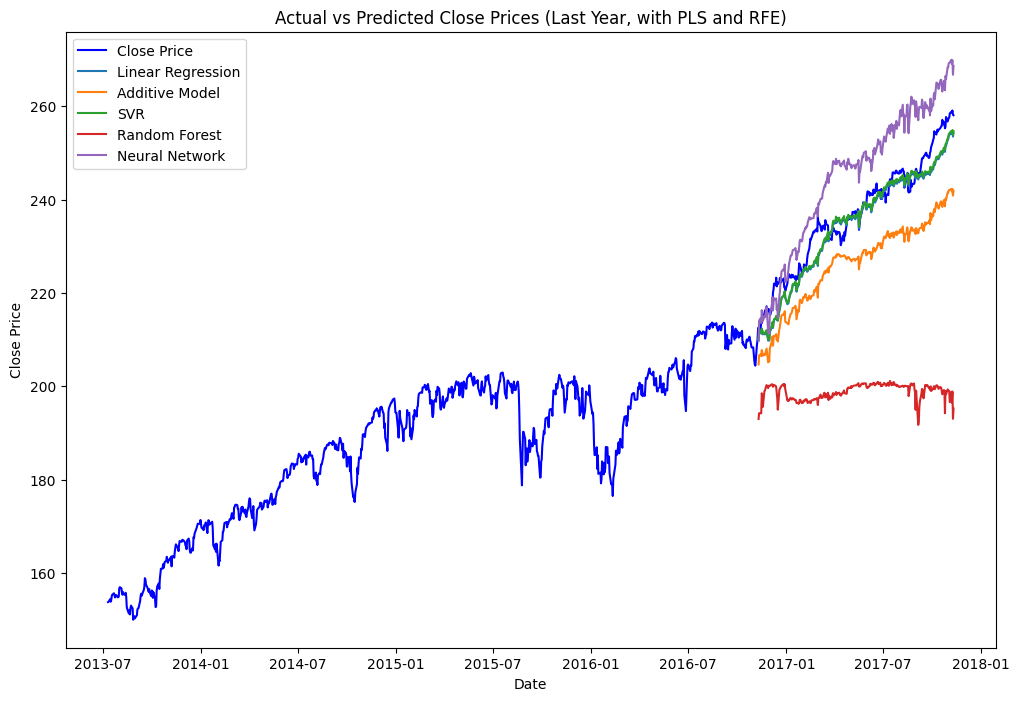

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pygam import LinearGAM, s
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.cross_decomposition import PLSRegression
from sklearn.feature_selection import RFE

# Function for creating date features
def create_date_features(df):
    df['DayOfYear'] = df.index.dayofyear
    df['WeekOfYear'] = df.index.isocalendar().week
    df['Month'] = df.index.month
    df['Year'] = df.index.year
    df['DayOfYear_sin'] = np.sin(2 * np.pi * df['DayOfYear'] / 365.25)
    df['DayOfYear_cos'] = np.cos(2 * np.pi * df['DayOfYear'] / 365.25)
    df['WeekOfYear_sin'] = np.sin(2 * np.pi * df['WeekOfYear'] / 52)
    df['WeekOfYear_cos'] = np.cos(2 * np.pi * df['WeekOfYear'] / 52)
    df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
    df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)
    return df

# Load data
df = pd.read_csv('../../data/stock-market/ETFs/spy.us.txt')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Create lagged features
for i in range(12, 37):
    for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
        df[f'{col}_lag_{i}'] = df[col].shift(i)
df.dropna(inplace=True)

# Feature engineering
df = create_date_features(df)

# Define target and features
y = df['Close']
features = [col for col in df.columns if col != 'Close']
X = df[features]

# Define date ranges for train, validation, and test sets
end_date = df.index.max()
test_start_date = end_date - pd.DateOffset(years=1)
val_start_date = test_start_date - pd.DateOffset(years=1)

train_X = X[X.index < val_start_date]
train_y = y[X.index < val_start_date]
val_X = X[(X.index >= val_start_date) & (X.index < test_start_date)]
val_y = y[(y.index >= val_start_date) & (y.index < test_start_date)]
test_X = X[X.index >= test_start_date]
test_y = y[X.index >= test_start_date]

# Normalize features
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)
train_X_normalized = X_normalized[X.index < val_start_date]
val_X_normalized = X_normalized[(X.index >= val_start_date) & (X.index < test_start_date)]
test_X_normalized = X_normalized[X.index >= test_start_date]

# PLS dimensionality reduction
pls = PLSRegression(n_components=X.shape[1])
pls.fit(train_X_normalized, train_y)
cumulative_variance = np.cumsum(np.sum(pls.x_scores_**2, axis=0) / np.sum(pls.x_scores_**2))
n_components = np.argmax(cumulative_variance >= 0.95) + 1
pls = PLSRegression(n_components=n_components)
X_pls = pls.fit_transform(X_normalized, y)[0]
train_X_pls = X_pls[:len(train_X)]
val_X_pls = X_pls[len(train_X):len(train_X) + len(val_X)]
test_X_pls = X_pls[len(train_X) + len(val_X):]

# RFE feature selection
rfe = RFE(estimator=LinearRegression(), n_features_to_select=10)
X_rfe = rfe.fit_transform(X_pls, y)
train_X_rfe = X_rfe[:len(train_X)]
val_X_rfe = X_rfe[len(train_X):len(train_X) + len(val_X)]
test_X_rfe = X_rfe[len(train_X) + len(val_X):]

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Additive Model': LinearGAM(s(0, n_splines=20, lam=0.1) + s(1, n_splines=20, lam=0.1) +
                                s(2, n_splines=20, lam=0.1) + s(3, n_splines=20, lam=0.1) +
                                s(4, n_splines=20, lam=0.1)),
    'SVR': SVR(kernel='linear', C=100, epsilon=5),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Neural Network': MLPRegressor(hidden_layer_sizes=(50, 50), max_iter=2000, learning_rate_init=0.001, alpha=0.01),
}

# Decomposition (Additive Model)
decomposition = seasonal_decompose(train_y, model='additive', period=365)
train_y_detrended = train_y - decomposition.trend.dropna()

# Train models and generate predictions
predictions = {}
for name, model in models.items():
    if name == 'Linear Regression':
        model.fit(train_X_rfe, train_y)
        full_pred = model.predict(X_rfe)
        val_pred = full_pred[len(train_X):len(train_X) + len(val_X)]
        test_pred = full_pred[len(train_X) + len(val_X):]
    else:
        model.fit(train_X_rfe, train_y if name == 'Additive Model' else train_y)
        val_pred = model.predict(val_X_rfe)
        test_pred = model.predict(test_X_rfe)
    predictions[name] = (val_pred, test_pred)

# Add actual values for comparison
val_df = pd.DataFrame({name: pred[0] for name, pred in predictions.items()}, index=val_X.index)
val_df['Actual'] = val_y
test_df = pd.DataFrame({name: pred[1] for name, pred in predictions.items()}, index=test_X.index)
test_df['Actual'] = test_y

# Save train, validation, and test datasets to CSV
train_X_rfe.to_csv('train_X.csv')
train_y.to_csv('train_y.csv')
val_X_rfe.to_csv('val_X.csv')
val_y.to_csv('val_y.csv')
test_X_rfe.to_csv('test_X.csv')
test_y.to_csv('test_y.csv')

# Calculate and display RMSE for each model
for name, (val_pred, test_pred) in predictions.items():
    val_rmse = np.sqrt(mean_squared_error(val_y, val_pred))
    test_rmse = np.sqrt(mean_squared_error(test_y, test_pred))
    print(f"{name} Validation RMSE: {val_rmse:.2f}")
    print(f"{name} Test RMSE: {test_rmse:.2f}")

# Plot actual vs. predicted prices
plt.figure(figsize=(12, 8))
plt.plot(df.index[-3*365:], df['Close'][-3*365:], label='Close Price', color='blue')

for name, (_, test_pred) in predictions.items():
    plt.plot(test_y.index, test_pred, label=name)

plt.title("Actual vs Predicted Close Prices (Last Year, with PLS and RFE)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()
